# EDA & Data Cleaning Example

## Dataset

We're going to be using the Kaggle Stumbleupon dataset 




## Import Modules

In [2]:
import pandas as pd
import numpy as np
from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import cross_val_score
import statsmodels.formula.api as smf
import patsy
from patsy import dmatrices
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
%matplotlib inline

## Preprocessing

First, let's load in the dataset. It's always important to visually examine the data, so let's go ahead and give it a look

In [3]:
ev = pd.read_csv('/users/patricksmith/desktop/evergreen.tsv', delimiter='\t')
ev.head()

,url,urlid,boilerplate,alchemy_category,alchemy_category_score,avglinksize,commonlinkratio_1,commonlinkratio_2,commonlinkratio_3,commonlinkratio_4,...,is_news,lengthyLinkDomain,linkwordscore,news_front_page,non_markup_alphanum_characters,numberOfLinks,numwords_in_url,parametrizedLinkRatio,spelling_errors_ratio,label
0,http://www.bloomberg.com/news/2010-12-23/ibm-p...,4042,"{""title"":""IBM Sees Holographic Calls Air Breat...",business,0.789131,2.055556,0.676471,0.205882,0.047059,0.023529,...,1,1,24,0,5424,170,8,0.152941,0.079130,0
1,http://www.popsci.com/technology/article/2012-...,8471,"{""title"":""The Fully Electronic Futuristic Star...",recreation,0.574147,3.677966,0.508021,0.288770,0.213904,0.144385,...,1,1,40,0,4973,187,9,0.181818,0.125448,1
2,http://www.menshealth.com/health/flu-fighting-...,1164,"{""title"":""Fruits that Fight the Flu fruits tha...",health,0.996526,2.382883,0.562016,0.321705,0.120155,0.042636,...,1,1,55,0,2240,258,11,0.166667,0.057613,1
3,http://www.dumblittleman.com/2007/12/10-foolpr...,6684,"{""title"":""10 Foolproof Tips for Better Sleep ""...",health,0.801248,1.543103,0.400000,0.100000,0.016667,0.000000,...,1,0,24,0,2737,120,5,0.041667,0.100858,1
4,http://bleacherreport.com/articles/1205138-the...,9006,"{""title"":""The 50 Coolest Jerseys You Didn t Kn...",sports,0.719157,2.676471,0.500000,0.222222,0.123457,0.043210,...,1,1,14,0,12032,162,10,0.098765,0.082569,0


##  Preprocessing

When we first look at a new dataset, it's important to understand certain characteristics about it. A basic use of `shape` as well as `dtypes` will give us a general idea of what our data looks like. 

In [4]:
ev.shape

(7395, 27)

In [5]:
ev.dtypes

url                                object
urlid                               int64
boilerplate                        object
alchemy_category                   object
alchemy_category_score             object
avglinksize                       float64
commonlinkratio_1                 float64
commonlinkratio_2                 float64
commonlinkratio_3                 float64
commonlinkratio_4                 float64
compression_ratio                 float64
embed_ratio                       float64
framebased                          int64
frameTagRatio                     float64
hasDomainLink                       int64
html_ratio                        float64
image_ratio                       float64
is_news                            object
lengthyLinkDomain                   int64
linkwordscore                       int64
news_front_page                    object
non_markup_alphanum_characters      int64
numberOfLinks                       int64
numwords_in_url                   

It's always good to compare these data types to what we would expect to see when visually examining our data. Notice that `is_news`,`news_front_page`, and `alchemy_category_score` are incorrectly coded as objects - the pythonic name for a string-type. We'll want to take a closer look at these. 

We can do that simply by using .unique() to check for unique values in each column:

In [6]:
ev.is_news.unique()

array(['1', '?'], dtype=object)

Notice that we question marks in our data instead of another binary label. We'll what to remap the question marks to represent *0s* instead, which we can easily do utilizing Python's map function combined with a lambda function to easily handle this.

In [7]:
ev['is_news'] = ev.is_news.map(lambda x: 0 if x == '?' else 1)

Now, let's take a look at the *news_front_page* column: 

In [8]:
ev.news_front_page.unique()

array(['0', '?', '1'], dtype=object)

We can write a function to replace the question marks here with zeros as well:

In [9]:
def replace(x):
    if x == '?':
        return float(0)
    else:
        return float(x)
    
ev['news_front_page'] = ev.news_front_page.map(replace)

Lastly, let's take a look at `alchemy_category_score`:

In [10]:
ev.alchemy_category_score.unique()

array(['0.789131', '0.574147', '0.996526', ..., '0.14192', '0.196273',
       '0.617876'], dtype=object)

As you can see, these clearly aren't strings! Let's write a function to convert these scores to floats, including a condition to handle edge cases that can't be converted. I'll convert these to NAN's and deal with them later on. 

In [11]:
def replaceScore(x):
    try:
        return float(x)
    except:
        return np.nan
    
ev['alchemy_category_score'] = ev.alchemy_category_score.map(replaceScore)

Lastly, let's take a look at the `alchemy_category` column:

In [12]:
ev.alchemy_category.unique()

array(['business', 'recreation', 'health', 'sports', '?',
       'arts_entertainment', 'science_technology', 'gaming',
       'culture_politics', 'computer_internet', 'law_crime', 'religion',
       'weather', 'unknown'], dtype=object)

It looks like we have the values of '?' and 'unknown', which are effectly the same value. So how do we handle this? 

We can first start by converting each of the question marks into a unknown value.

In [13]:
ev['alchemy_category'] = ev.alchemy_category.map(lambda x: 'unknown' if x == '?' else x)

## Exploratory Data Analysis

Let's do some initial EDA to get an even better feel for our data

In [14]:
ev.groupby('alchemy_category').mean()

,urlid,alchemy_category_score,avglinksize,commonlinkratio_1,commonlinkratio_2,commonlinkratio_3,commonlinkratio_4,compression_ratio,embed_ratio,framebased,...,is_news,lengthyLinkDomain,linkwordscore,news_front_page,non_markup_alphanum_characters,numberOfLinks,numwords_in_url,parametrizedLinkRatio,spelling_errors_ratio,label
alchemy_category,,,,,,,,,,,,,,,,,,,,,
arts_entertainment,5282.924548,0.635563,2.589265,0.435978,0.196893,0.085662,0.045975,1.398077,-0.062806,0.0,...,0.753454,0.643996,29.933050,0.063762,5799.317747,178.555792,4.823592,0.185572,0.100828,0.371945
business,5185.118182,0.610034,2.866954,0.469868,0.216449,0.093442,0.051227,1.044285,-0.055398,0.0,...,0.684091,0.690909,28.430682,0.044318,5331.531818,190.580682,5.034091,0.179033,0.090234,0.711364
computer_internet,5405.131757,0.702846,3.642673,0.463554,0.214057,0.089813,0.054457,1.346886,-0.050093,0.0,...,0.743243,0.689189,32.827703,0.023649,4252.986486,155.655405,5.604730,0.175133,0.101900,0.246622
culture_politics,5437.702624,0.577337,4.212783,0.479214,0.218812,0.101380,0.058570,1.222569,-0.056870,0.0,...,0.705539,0.728863,31.241983,0.043732,6068.034985,191.635569,5.250729,0.159529,0.093682,0.457726
gaming,4826.184211,0.505969,2.454487,0.333959,0.138273,0.059195,0.030920,3.107140,-0.142401,0.0,...,0.644737,0.513158,29.526316,0.026316,4404.381579,134.671053,4.381579,0.181900,0.114138,0.368421
health,5438.217391,0.705927,3.233397,0.529462,0.254992,0.099043,0.043573,1.322775,-0.045306,0.0,...,0.679842,0.743083,28.709486,0.025692,6224.420949,162.440711,5.602767,0.155042,0.098498,0.573123
law_crime,5619.096774,0.499999,2.603905,0.470935,0.205460,0.095772,0.056749,3.194900,-0.128400,0.0,...,0.677419,0.645161,37.709677,0.032258,3398.000000,130.161290,4.870968,0.138358,0.114294,0.419355
recreation,5325.001627,0.527897,2.712232,0.460888,0.212855,0.093616,0.051932,1.452804,-0.064736,0.0,...,0.669650,0.625712,29.804719,0.064280,5026.894223,187.813670,4.706265,0.177550,0.095933,0.684296
religion,5239.847222,0.426596,3.223695,0.424185,0.211026,0.088241,0.048864,2.558645,-0.110914,0.0,...,0.638889,0.611111,37.750000,0.000000,4224.694444,155.250000,4.458333,0.156488,0.116062,0.416667


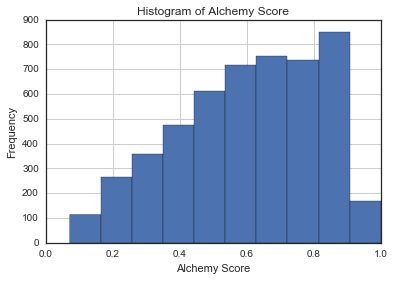

In [8]:
ev.alchemy_category_score.hist()
plt.title('Histogram of Alchemy Score')
plt.xlabel('Alchemy Score')
plt.ylabel('Frequency')

This is useful, as we can see that the Alchemy API is reletively sure that it's category predictions are accurate. 

## Handling Missing Data

Earlier we handled some miscoded elements in our data, now let's look at the null values. 

Let's go ahead and create a function that finds each unique value in `alchemy_category` and returns a ratio of the null values associated with each category.

We can do this by *first* creating our function and then *applying* it on the `alchemy_category` column. `.apply` is useful in this instance as it allows us to take a function like `NullsCat` and applying across a slice of a dataframe. 

In [9]:
def NullsCat(df):
    print df.alchemy_category.unique()[0], sum(df.alchemy_category_score.isnull())/float(len(df.alchemy_category))
    return df
    
tmp = ev.groupby('alchemy_category').apply(NullsCat)

arts_entertainment 0.0
arts_entertainment 0.0
business 0.0
computer_internet 0.0
culture_politics 0.0
gaming 0.0
health 0.0
law_crime 0.0
recreation 0.0
religion 0.0
science_technology 0.0
sports 0.0
unknown 0.997444633731
weather 0.0


Looking at this, one of our categories have any NA values except for the unknown category - which we expected. So how to we handle this missing data?

For missing values such as these; there are three approaches that I typically take. We can either: 

1. Drop the missing values
2. Impute the mean
3. Utilizing KNN imputation

Since unknown potentially doesn't have much use to us, we could simply eliminate the missing values. However for the sake of demonstration, I'm going to impute the missing values.

In [10]:
all_category_mean = ev.alchemy_category_score.mean()
all_category_std = ev.alchemy_category_score.std()
unknown_category_mean = ev[ev.alchemy_category == 'unknown'].alchemy_category_score.mean()
unknown_category_std = ev[ev.alchemy_category == 'unknown'].alchemy_category_score.std()

print 'All categories score mean: ', all_category_mean
print 'All categories score std: ', all_category_std
print 'Unknown category score mean: ', unknown_category_mean
print 'Unknown category score std: ', unknown_category_std

All categories score mean:  0.603334316624
All categories score std:  0.212863859741
Unknown category score mean:  0.400001
Unknown category score std:  0.0


I'm going to fill in the unknown scores using a random normal distribution with mean set to the mean of the unknown column and standard deviation set to the std of all the categories. (I can't use the standard deviation of the unknown group since it is zero!)

In [11]:
mask = (ev.alchemy_category_score.isnull()) & (ev.alchemy_category == 'unknown')

In [12]:
new_scores = np.random.normal(loc=unknown_category_mean, 
                              scale=all_category_std,
                              size=len(mask))
print new_scores[0:10]

[ 0.41687677  0.2059227   0.53875538  0.21832469  0.09325238  0.29845822
  0.56239423  0.39882666  0.19376149  0.33616626]


In [13]:
ev.ix[mask, 'alchemy_category_score'] = new_scores

Let's check out the new unknown score distribution mean and standard deviation.

In [14]:
new_unknown_category_mean = ev[ev.alchemy_category == 'unknown'].alchemy_category_score.mean()
new_unknown_category_std = ev[ev.alchemy_category == 'unknown'].alchemy_category_score.std()

print 'Unknown category score mean: ', new_unknown_category_mean
print 'Unknown category score std: ', new_unknown_category_std

Unknown category score mean:  0.405711133692
Unknown category score std:  0.218539641806


As a precautionary measures, lets take a look at the labels to ensure they are binary.

In [ ]:
ev.label.unique()